# David Fleming, HW1

In [1]:
%matplotlib inline

from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import os
from astropy.table import Table
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (8,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['font.size'] = 20.0

## Define useful plotting functions

In [2]:
# Given a pandas dataframe, plot the ra/dec
def plot_ra_dec(data, ax, size = 0.1):
    ax.scatter(data['ra'], data['dec'], marker='.', s=size)

    ax.invert_xaxis()

    ax.set_xlim(data['ra'].max(), data['ra'].min())
    ax.set_ylim(data['dec'].min(), data['dec'].max())

    ax.set_xlabel("R.A. [$^{\circ}$]")
    ax.set_ylabel("$\delta$ [$^{\circ}$]")
    
# Given a pandas dataframe, plot g-r CMD
def add_cmd(ax, data, size = 0.1):
    g = data['g']
    r = data['r']
    gr = g - r

    ax.scatter(gr, r, marker='.', s = size)

    ax.set_xlim(-1, 2.5)
    ax.set_ylim(15, 22)

    ax.invert_yaxis()

    ax.set_xlabel("g - r")
    ax.set_ylabel("r")

# Problem 1: Querying and data analysis with SDSS

# 1

Use the schema browser to familiarize yourself with the contents of a view named Star. Then:
### Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).

---

Below is the SQL query I entered into CasJobs to count how many stars have been observed with SDSS in DR12

```
select 
  COUNT(*) as star_num 

from 
  Star
  
where 
  probPSF = 1
  
into
  mydb.fieldq11
```

The result of this query is 260562744.

### Write (and execute) an SQL query to count how many observations there are in u, g, r, i and z bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?

---

Below is the SQL query I entered to count the number and average of the observed PSF magnitude in each SDSS band:
```
SELECT 
  COUNT(u) as u, AVG(u) as avg_u,
  COUNT(g) as g, AVG(g) as avg_g, 
  COUNT(r) as r, AVG(r) as avg_r, 
  COUNT(i) as i, AVG(i) as avg_i, 
  COUNT(z) as z, AVG(z) as avg_z 

from 
  Star
  
where
  probPSF = 1
  
into
  mydb.field2
```

---

Results of the query:
```
u	        avg_u	            g	        avg_g	            r	        avg_r	            i	
260562744	23.2666983918094	260562744	22.1272313754313	260562744	21.0866780482269	260562744
avg_i	            z	        avg_z
20.3136961319675	260562744	19.8299030650937
```

Since SDSS records missing data as -9999.0, I ran the following query to get the counts and average magnitudes for DR12 for all objects without missing data:

```
SELECT 
  COUNT(u), AVG(u) as avg_u,
  COUNT(g), AVG(g) as avg_g, 
  COUNT(r), AVG(r) as avg_r, 
  COUNT(i), AVG(i) as avg_i, 
  COUNT(z), AVG(z) as avg_z 
  
from 
  Star  
  
WHERE
  u > -9999.0 AND (g > -9999.0) AND (r > -9999.0) AND (i > -9999.0) AND (z > -9999.0) AND (probPSF = 1)
  
into
  mydb.fieldq12
```

---

Results of the query:
```
u	        avg_u	            g	        avg_g	            r	        avg_r	            i	
260556474	23.3289490038642	260556474	22.2163556267409	260556474	21.1341583382616	260556474
avg_i	            z	        avg_z
20.4050642508287	260556474	19.8843833112234
```

From the second query, we can see that 6270 stars had missing u, g, r, i or z magnitudes and that the averages found shifted by filtering out the -9999 default missing values value.

# 2

### Write an SQL query to select the positions (α, also known as ra, and δ, also know as dec) and the extinction-corrected (a.k.a. dereddened) g and r-band magnitudes of all stars bounded by 225<$
\alpha$<235 and −2.5<$\delta$<4. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file.

---

Query I used to select the proper dereddened g and r magnitudes in the given ra and dec range.
```
select
  ra as ra,
  dec as dec,
  dered_g as g,
  dered_r as r
  
from 
  Star  
  
where
  g > -9999.0 and r > -9999.0 and ra > 225 and ra < 235 and dec > -2.5 and dec < 4 and probPSF = 1
  
into
  mydb.fieldq21
 ```

### Use the astropy.tables module to load the table data into Python.

---

In [3]:
fieldq21 = Table.read('fieldq21.fit')

### Store it into a local sqlite database (using Pandas to_sql() functions).

---

In [4]:
# Port astropy table to pandas dataframe
field_df = fieldq21.to_pandas()

In [5]:
# Port pandas dataframe to sqlite database
con = sqlite3.connect('field21.db')
field_df.to_sql('field', con, flavor='sqlite', if_exists='replace')

# 3

### In an IPython notebook, make an ra vs dec scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that.

---

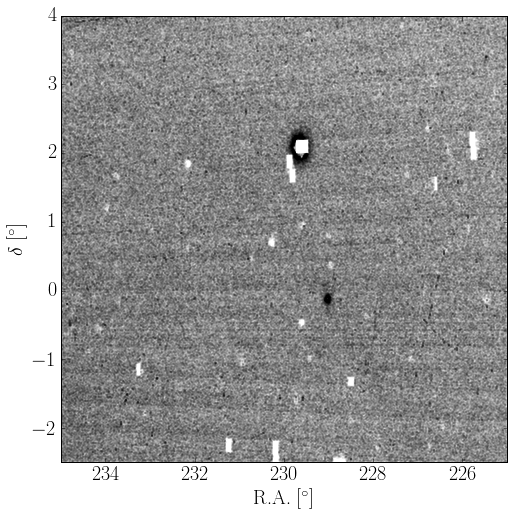

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
plot_ra_dec(data=field_df, ax=ax, size = 0.005)

### What do you see near α∼229 and δ∼0? Do know what is this object?

---

This object is the globular cluster Pal 5.  It's coordinates in RA and dec are 229.0128 and -0.1082, both in degrees.  It has a size of about 3 arcmin on the sky.

# 4

### Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but away from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results (it's sufficient to show they return the same number of rows for the same constraints).

---

#### Make a cut of stars around the object for [228.7,229.3] in ra and [-0.3,0.1] in dec.  Check the length of the results and plot them to ensure that they are the same.

---

My query and my indexing of the pandas DataFrame returns the same data set. See the below plots and code as well.

In [7]:
sql_cut_obj = pd.read_sql("""SELECT ra as ra, dec as dec, g as g, r as r 
FROM field WHERE (ra > 228.7) AND (ra < 229.3) AND (dec > -0.3) AND (dec < 0.1)""",con)

In [8]:
print(len(sql_cut_obj))

6187


In [9]:
cond = (field_df['ra'] > 228.7) & (field_df['ra'] < 229.3) & (field_df['dec'] > -0.3) & (field_df['dec'] < 0.1)
pd_cut_obj = field_df[cond]

In [10]:
print(len(pd_cut_obj))

6187


The lengths of the results of the queries agree!

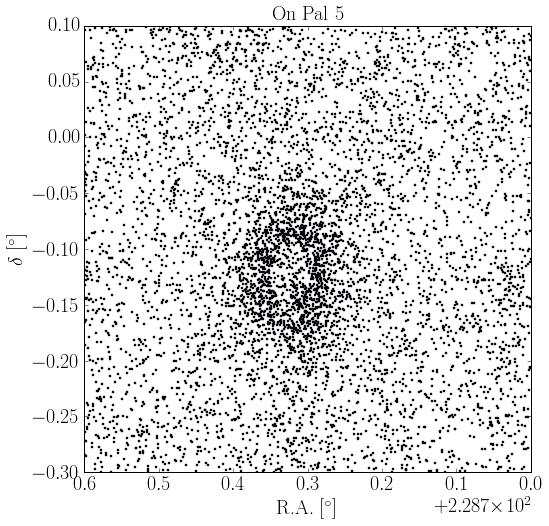

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
plot_ra_dec(data=pd_cut_obj, ax=ax, size=10)
ax.set_title("On Pal 5")

#### Make a cut of stars away from Pal 5 for [229.7,230.3] in ra and [-0.3,0.1] in dec.  Check the length of the results and plot them to ensure that they are the same.

---

My query and my indexing of the pandas DataFrame returns the same data set.

In [12]:
sql_cut_off = pd.read_sql("""SELECT ra as ra, dec as dec, g as g, r as r 
FROM field WHERE (ra > 229.7) AND (ra < 230.3) AND (dec > -0.3) AND (dec < 0.1)""",con)

In [13]:
print(len(sql_cut_off))

4104


In [14]:
cond = (field_df['ra'] > 229.7) & (field_df['ra'] < 230.3) & (field_df['dec'] > -0.3) & (field_df['dec'] < 0.1)
pd_cut_off = field_df[cond]

In [15]:
print(len(pd_cut_off))

4104


The lengths of the results of the queries agree!

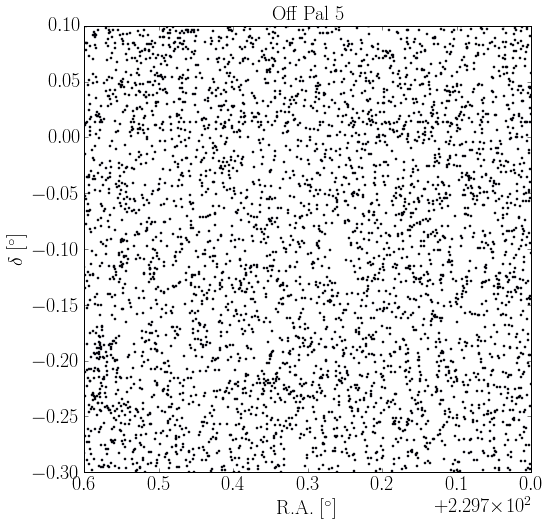

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
plot_ra_dec(data=pd_cut_off, ax=ax, size=10)
ax.set_title("Off Pal 5")

# 5

### Make two side-by-side scatter plots of the (dereddened) g−r color vs g-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. 

---

See the below code, plots.

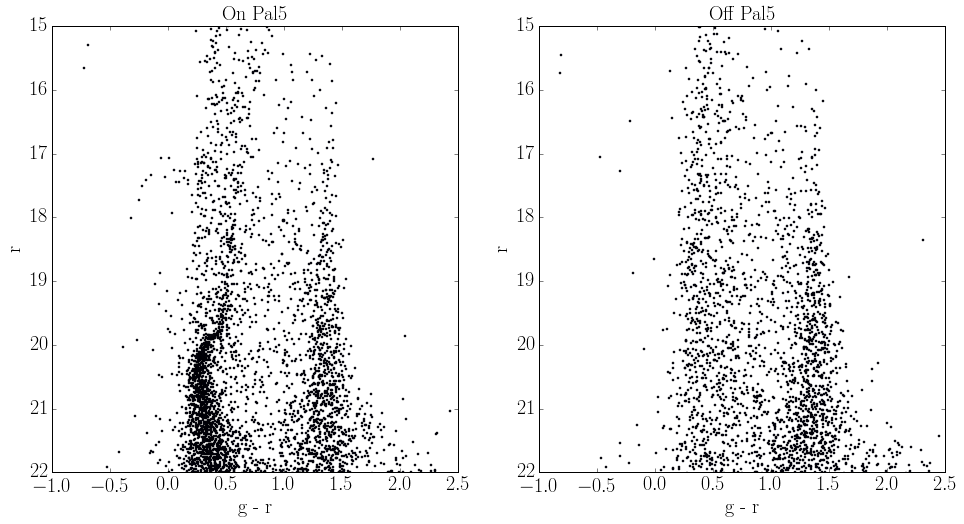

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
add_cmd(ax=axes[0], data=pd_cut_obj, size=10)
add_cmd(ax=axes[1], data=pd_cut_off, size=10)

axes[0].set_title("On Pal5")
axes[1].set_title("Off Pal5")

### Compare the two and describe what you see.

---

In the left panel at a g-r of about 0.25, we see the presence of a main sequence and red giant branch.  Since this feature does not exist in the right plot which represents the field, we can infer that the feature is a separate stellar population, the globular cluster Pal 5.

# 6

### Identify a region in g−r vs g plot where the difference between the two plots appears greatest. 

---

From the above plots, [0,0.75] in g-r and [22,18] in r is the region where both plots differ the most.

### From your original sample, select stars only present in that color-magnitude box, and plot them in ra vs dec scatter plot. 

---

In [18]:
cond = (field_df['r'] > 18.0) & (field_df['r'] < 22.0) & (field_df['g']-field_df['r'] > 0.0) & \
        (field_df['g']-field_df['r'] < 0.75)
cmd_cut = field_df[cond]

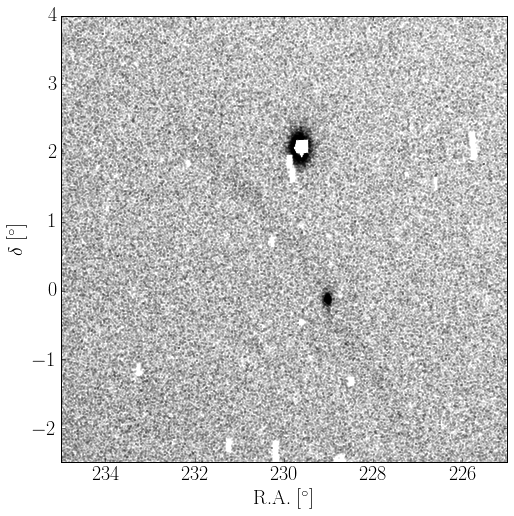

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
plot_ra_dec(data=cmd_cut, ax=ax, size=0.05)

### Do you notice anything interesting?

---

From the above scatter plot, it appears as if a slightly overdense stream crosses the field and intersects Pal 5.  The steam goes from a (ra,dec) of (232,2) to about (228.5,-2).

# 7

### Extra credit: How would you make the determination of the selection box more quantitative?

---

One could histogram the data to see if multiple populations exist.  If they do, to first order, one could select the edges by taking the median of the new population and setting the boundaries to be one standard deviation.

# Problem 2: Importing data into the Large Survey Database

# 1

### Install the Large Survey Database (see Lecture #3 for instructions)

---

LSD is installed on the UW network, so I'll just use that.

##### Configure workstation so I know where LSD is for imports, etc

In [20]:
! conda config --add channels http://www.astro.washington.edu/users/mjuric/conda

Skipping channels: http://www.astro.washington.edu/users/mjuric/conda, item already exists


##### Set the LSD environ variables so I don't brick my machine or the network.  All temp, lsddb actions will take place on my machine's /local/tmp disk space (~ 300 gb)

In [21]:
os.environ['NWORKERS'] = '2'
os.environ['LSD_CACHEDIR'] = '/local/tmp/lsd_tmp'
os.environ['LSD_TEMPDIR'] = '/local/tmp/lsd_tmp'
os.environ['LSD_DB'] = '/local/tmp/lsd_tmp' + '/lsddb:/astro/apps6/opt/lsddb'
os.environ['HW1_DATADIR'] = '/local/tmp/lsd_tmp/lsd_hw1_data'

### Confirm it works.

---

If the imports work, I can use lsd.

In [22]:
from lsd import DB
from lsd.bounds import beam, rectangle

# 2

### Read about the data contained in sweep files for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information.

---

Read the following links: 

http://dr12.sdss3.org/datamodel/

http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html

Using this information, I wrote the .yaml file given below that will be used to create a lsd table with the proper schema.

##### cd to where my import.yaml is.

In [23]:
os.chdir('/astro/users/dflemin3/Dropbox/UW_notebooks/astr597b_wi16_hw')

In [24]:
! cat import.yaml

# Schema for SDSS star sweep run 94 table
# Has basic quantities, photometry, image, resolve, and calibration and 2MASS match info
filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: sdss_id
    spatial_keys: [RA, DEC]
    columns:
    - [sdss_id, u8]
    - [RA, f8]
    - [DEC, f8]
    - [RUN, i2]
    - [RERUN, a3]
    - [CAMCOL, u8]
    - [FIELD, i2]
    - [ID, i2]
    - [OBJC_TYPE, i4]
    - [OBJC_FLAGS, i4]
    - [OBJC_FLAGS2, i4]
    - [OBJC_ROWC, f4]
    - [ROWVDEG, f4]
    - [ROWVDEGERR, f4]
    - [COLVDEG, f4]
    - [COLVDEGERR, f4]
    - [ROWC, 5f4]
    - [COLC, 5f4]
    - [M_RR_CC, 5f4]
    - [M_RR_CC_PSF, 5f4]
    - [FLAGS, 5i4]
    - [FLAGS2, 5i4]
    - [PSP_STATUS, 5i4]
  photometry:
    columns:
    - [EXTINCTION, 5f4]
    - [SKYFLUX, 5f4]
    - [PSFFLUX, 5f4]
    - [PSFFLUX_IVAR, 5f4]
    - [FIBERFLUX, 5f4]
    - [FIBERFLUX_IVAR, 5f4]
    - [FIBER2FLUX, 5f4]
    - [FIBER2FLUX_IVAR, 5f4]
    - [MODELFLUX, 5f4]
    - [MODELFLUX_IVAR, 5f4]
    - [CMODE

# Create the table.

---

Note: if the table already exists, add "--drop-existing"

In [25]:
! lsd-admin create table --drop-existing --schema=import.yaml sdss_94

Table 'sdss_94' dropped.

-------- committing 20160215195244.211610 [sdss_94] ---------
[sdss_94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.13 sec
[sdss_94] Updating neighbors: Already up to date.
[sdss_94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.13 sec
[sdss_94] Updating stats: [0 el.]>  0.00 sec
[sdss_94] Marking tablets read-only...
----------- success 20160215195244.211610 [sdss_94] ---------

Table 'sdss_94' created.


In [26]:
! lsd-admin desc table sdss_94

Path:          /local/tmp/lsd_tmp/lsddb/sdss_94
Partitioning:  level=6
(t0, dt):      54335.000000, 1.000000 
Rows:          0
Columns:       87
Primary key:   sdss_id
Spatial keys:  (RA, DEC)
Aliases:       []
Column groups: ['common', 'photometry', 'img_res_cal', 'TMASS_match']
-------------------------------
Column group 'common':
              Column       Type
-------------------------------
             sdss_id         u8
                  RA         f8
                 DEC         f8
                 RUN         i2
               RERUN         a3
              CAMCOL         u8
               FIELD         i2
                  ID         i2
           OBJC_TYPE         i4
          OBJC_FLAGS         i4
         OBJC_FLAGS2         i4
           OBJC_ROWC         f4
             ROWVDEG         f4
          ROWVDEGERR         f4
             COLVDEG         f4
          COLVDEGERR         f4
                ROWC        5f4
                COLC        5f4
             M_RR_CC    

### Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/.

---

Files were downloaded to /local/tmp/lsd_tmp/lsd_hw1_data.

### Use lsd-import to import these files.

---

In [42]:
RAW_DATA="/local/tmp/lsd_tmp/lsd_hw1_data"
! ls -l $RAW_DATA

total 775928
-rw-rw-r-- 1 dflemin3 dflemin3 129663360 Feb 10 15:09 calibObj-000094-1-star.fits
-rw-rw-r-- 1 dflemin3 dflemin3 150871680 Feb 10 15:10 calibObj-000094-2-star.fits
-rw-rw-r-- 1 dflemin3 dflemin3 121233600 Feb 10 15:10 calibObj-000094-3-star.fits
-rw-rw-r-- 1 dflemin3 dflemin3 126276480 Feb 10 15:10 calibObj-000094-4-star.fits
-rw-rw-r-- 1 dflemin3 dflemin3 132361920 Feb 10 15:10 calibObj-000094-5-star.fits
-rw-rw-r-- 1 dflemin3 dflemin3 134130240 Feb 10 15:11 calibObj-000094-6-star.fits


In [43]:
! lsd-import fits sdss_94 $RAW_DATA/*.fits

Importing from 6 pieces:
  ===> Imported /local/tmp/lsd_tmp/lsd_hw1_data/calibObj-000094-1-star.fits            [1/6, 16.67%] + 133515/133515     133515 (0/0 min.)
  ===> Imported /local/tmp/lsd_tmp/lsd_hw1_data/calibObj-000094-2-star.fits            [2/6, 33.33%] + 155355/155355     288870 (0/0 min.)
  ===> Imported /local/tmp/lsd_tmp/lsd_hw1_data/calibObj-000094-4-star.fits            [3/6, 50.00%] + 130027/130027     418897 (0/0 min.)
  ===> Imported /local/tmp/lsd_tmp/lsd_hw1_data/calibObj-000094-3-star.fits            [4/6, 66.67%] + 124832/124832     543729 (0/0 min.)
  ===> Imported /local/tmp/lsd_tmp/lsd_hw1_data/calibObj-000094-5-star.fits            [5/6, 83.33%] + 136292/136292     680021 (0/0 min.)
  ===> Imported /local/tmp/lsd_tmp/lsd_hw1_data/calibObj-000094-6-star.fits            [6/6, 100.00%] + 138113/138113     818134 (0/0 min.)
done

-------- committing 20160215195500.938107 [sdss_94] ---------
[sdss_94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.30 

### Use lsd-footprint to compute the footprint of the run.

---

First, cd to the tmp space.

In [44]:
os.chdir(RAW_DATA)

In [45]:
! ls

calibObj-000094-1-star.fits  calibObj-000094-4-star.fits
calibObj-000094-2-star.fits  calibObj-000094-5-star.fits
calibObj-000094-3-star.fits  calibObj-000094-6-star.fits


In [46]:
! lsd-footprint

Error: Incorrect number of command line arguments (0, expected 2).
Usage: /astro/apps6/opt/anaconda2.4/bin/lsd-footprint --db=dbdir --bounds=[All] --resolution=[2arcmin] --query=['_LON, _LAT FROM <table>'] <table> <output.fits>


In [47]:
! lsd-footprint --db=/local/tmp/lsd_tmp/lsddb --query='(RA + 180) % 360, DEC from sdss_94' sdss_94 foot.fits

 [48 el.]::::::::::::::::::::>  0.53 sec
Objects: 818134.0


### Plot the results.

---

Note: A little trial and error was used to zoom in on the data.

In [48]:
data = fits.open('foot.fits')[0].data

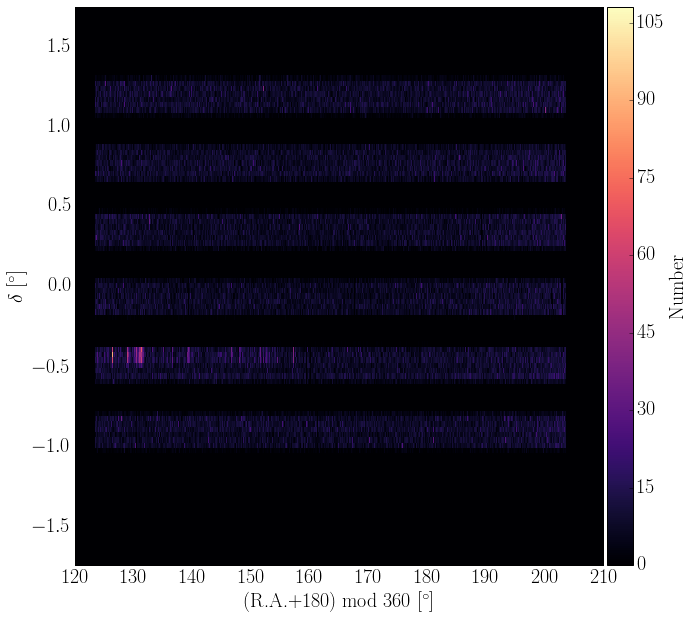

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

extent = (0, 360, -90, 90)

aspect = 'auto'

import copy
my_cmap = copy.copy(plt.cm.get_cmap('magma'))
my_cmap.set_bad((0,0,0))

im = ax.imshow(data, cmap=my_cmap, origin='lower left', extent=extent,
              aspect=aspect, interpolation='nearest')
ax.set_xlim(120,210)
ax.set_xlabel(r"(R.A.+180) mod 360 [$^{\circ}$]")

ax.set_ylim(-1.75,1.75)
ax.set_ylabel(r'$\delta$ [$^{\circ}$]')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, label='Number')